In [ ]:
library(Seurat)

### 多样本合并

In [4]:
# 直接全部读入，创建对象
samples = list.files("scRNA/")
dir = file.path('./scRNA', samples)
names(dir) = samples

counts = Read10X(data.dir = dir)
scRNA = CreateSeuratObject(counts, min.cells=1)
dim(scRNA)
table(scRNA@meta.data$orig.ident)
scRNA$group = substr(scRNA$orig.ident, 1,3)

# 计算MT、RB基因的百分比
scRNA[['percent.mt']] <- PercentageFeatureSet(scRNA, pattern="^MT-")
scRNA[['percent.rb']] <- PercentageFeatureSet(scRNA, pattern="^RP[SL]")

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


[1] 21522 30440


  423   424   425 
 8214 11323 10903 

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
“All cells have the same value of percent.mt.”


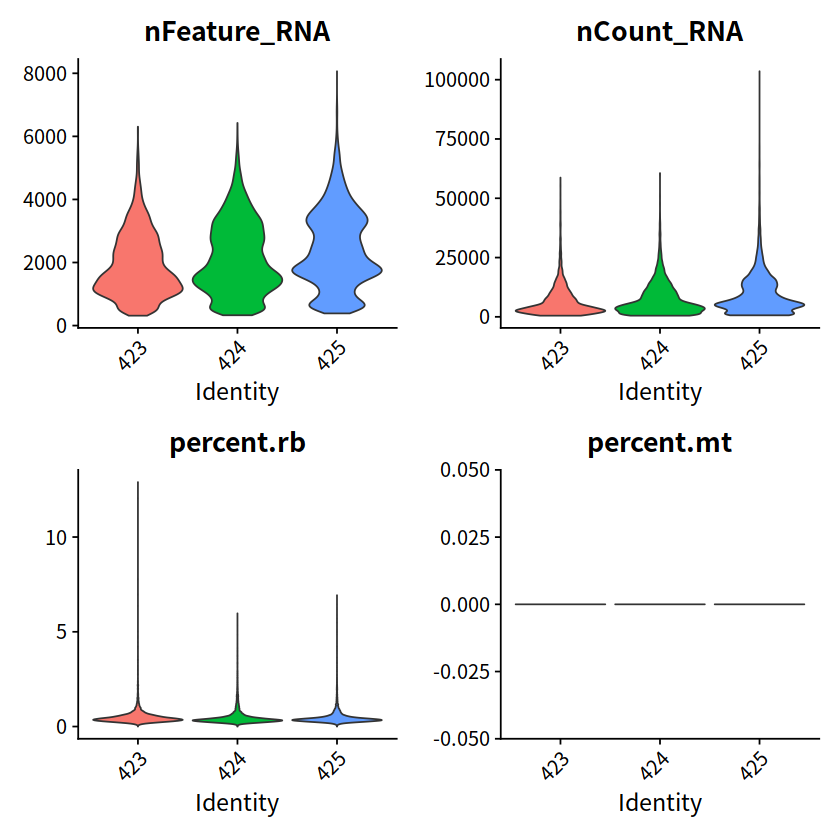

In [5]:
# 可视化每个细胞RNA的特证数
VlnPlot(scRNA, features = c("nFeature_RNA", "nCount_RNA", "percent.rb", "percent.mt"),
       pt.size=0, ncol=2)

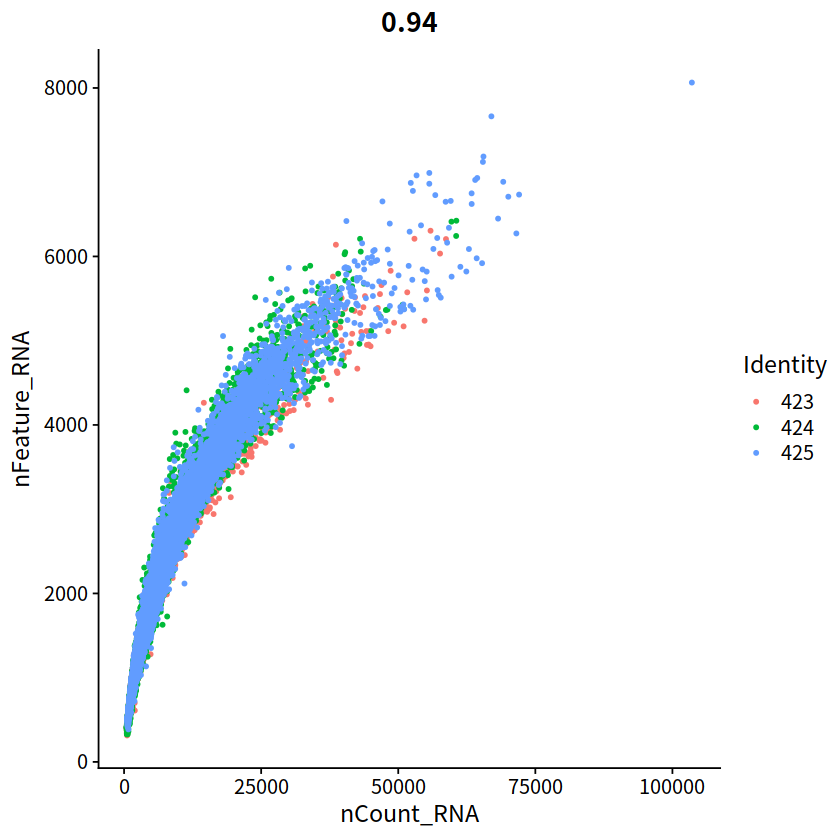

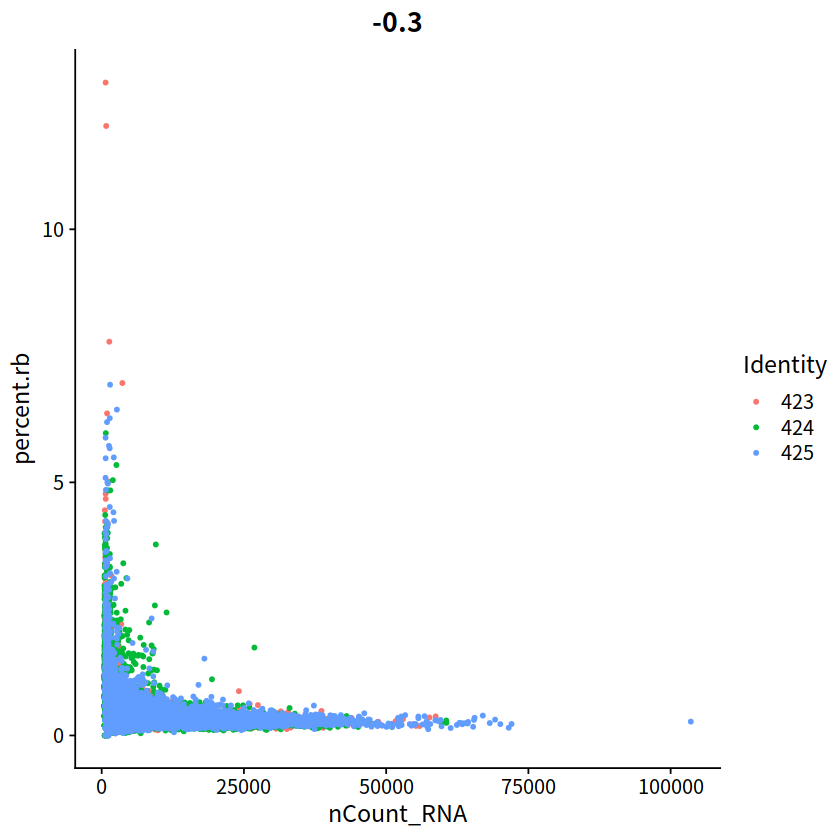

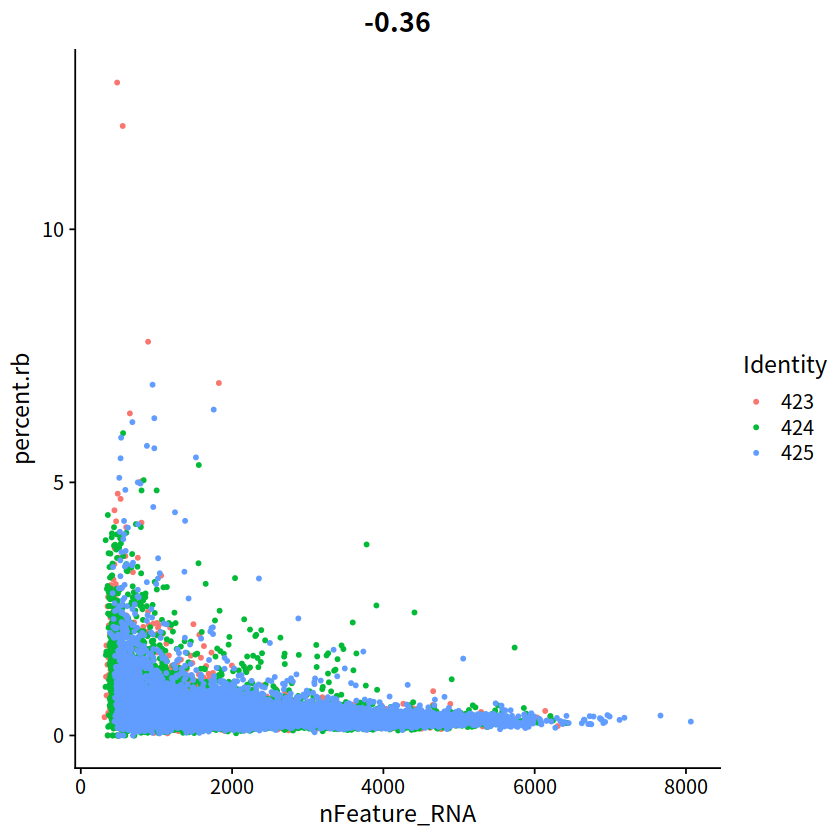

In [6]:
# 特征相关性
FeatureScatter(scRNA, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
FeatureScatter(scRNA, feature1 = "nCount_RNA", feature2 = "percent.rb")
FeatureScatter(scRNA, feature1 = "nFeature_RNA", feature2 = "percent.rb")

In [7]:
# 过滤
scRNA <- subset(scRNA, subset = nFeature_RNA > 200 & nFeature_RNA < 5000 & nCount_RNA < 30000)

# 标准化-归一化-高变基因（耗内存，用服务器跑吧）
scRNA <- NormalizeData(scRNA, normalization.method = "LogNormalize", scale.factor = 10000, verbose=FALSE)
scRNA <- FindVariableFeatures(scRNA, selection.method = "vst", nfeatures = 2000, verbose=FALSE)
scRNA <- ScaleData(scRNA, features = rownames(scRNA), verbose=FALSE)

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


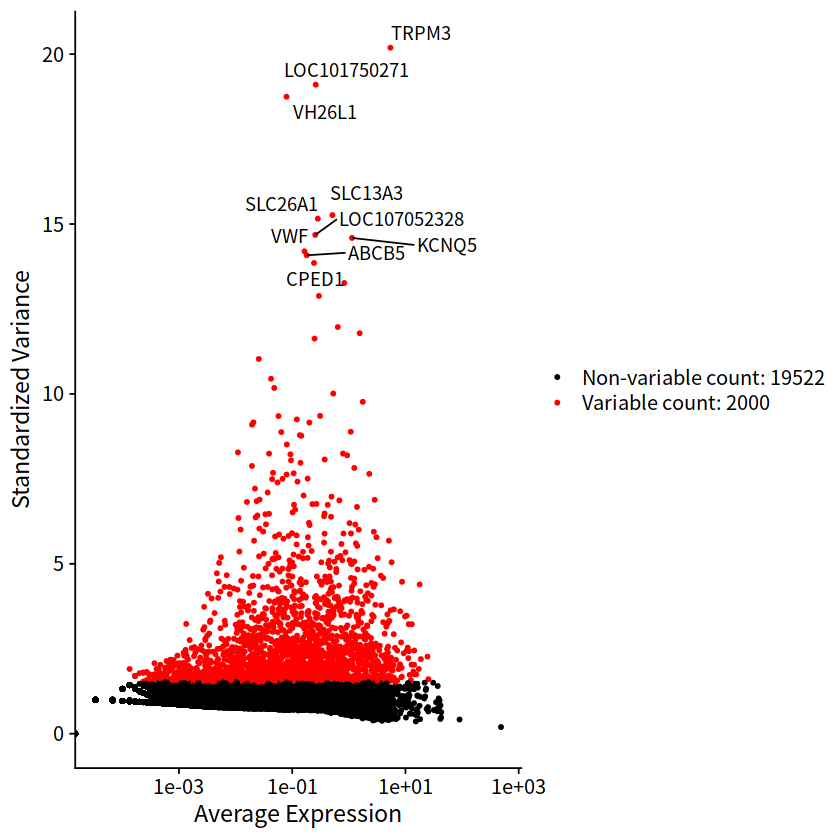

In [8]:
# 可视化高可变基因 hvg
top10 <- head(VariableFeatures(scRNA), 10)
p_hvg <- VariableFeaturePlot(scRNA)
LabelPoints(plot = p_hvg, points = top10, repel = TRUE, verbose=FALSE)

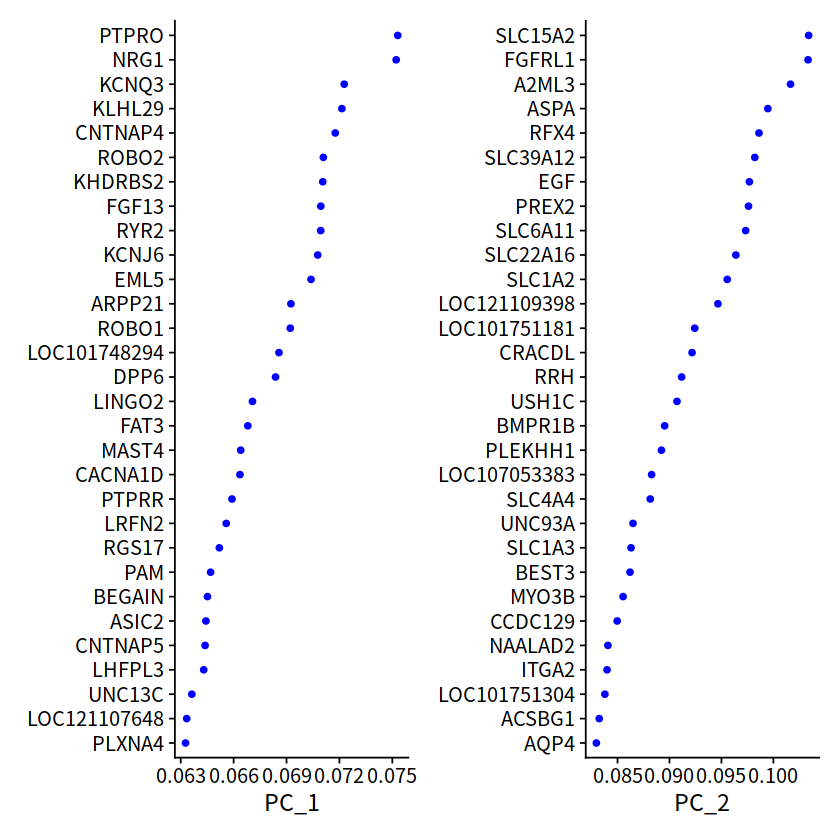

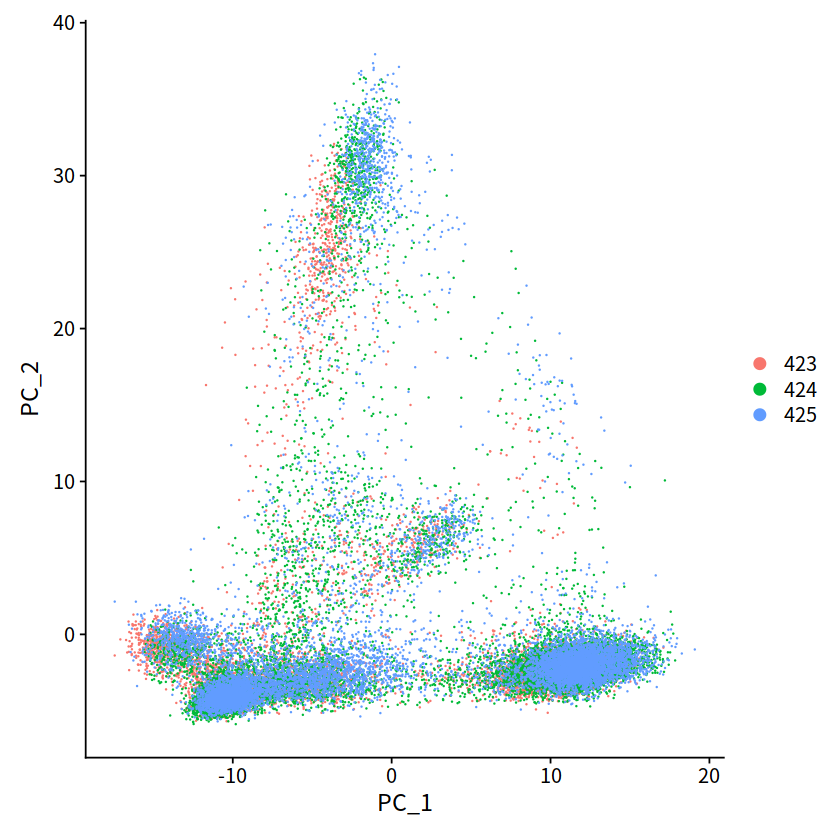

In [9]:
# PCA （耗内存，用服务器跑吧）
scRNA <- RunPCA(scRNA, features = VariableFeatures(scRNA), verbose=FALSE)
VizDimLoadings(scRNA, dims=1:2, reduction="pca")
DimPlot(scRNA, reduction="pca")

In [ ]:
# JackStraw法, 确定数据集维度（还是耗内存，不推荐）
scRNA <- JackStraw(scRNA, num.replicate=100) 
scRNA <- ScoreJackStraw(scRNA, dims = 1:20)
JackStrawPlot(scRNA, dims = 1:20)

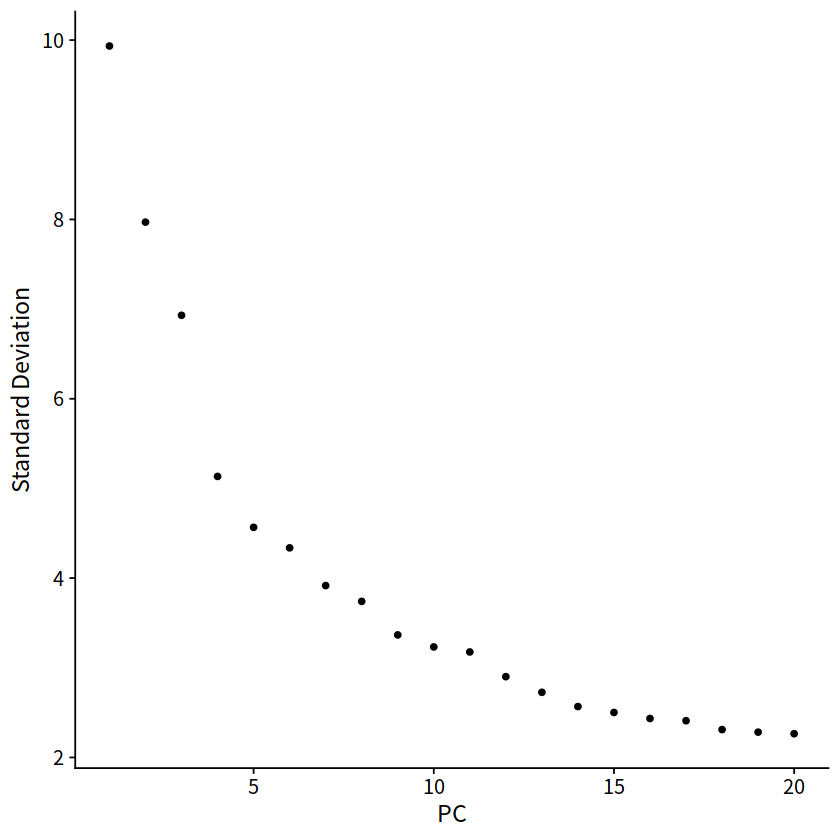

In [10]:
# 碎石图，确定维度 （推荐）
ElbowPlot(scRNA, reduction="pca", ndims=20) 

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


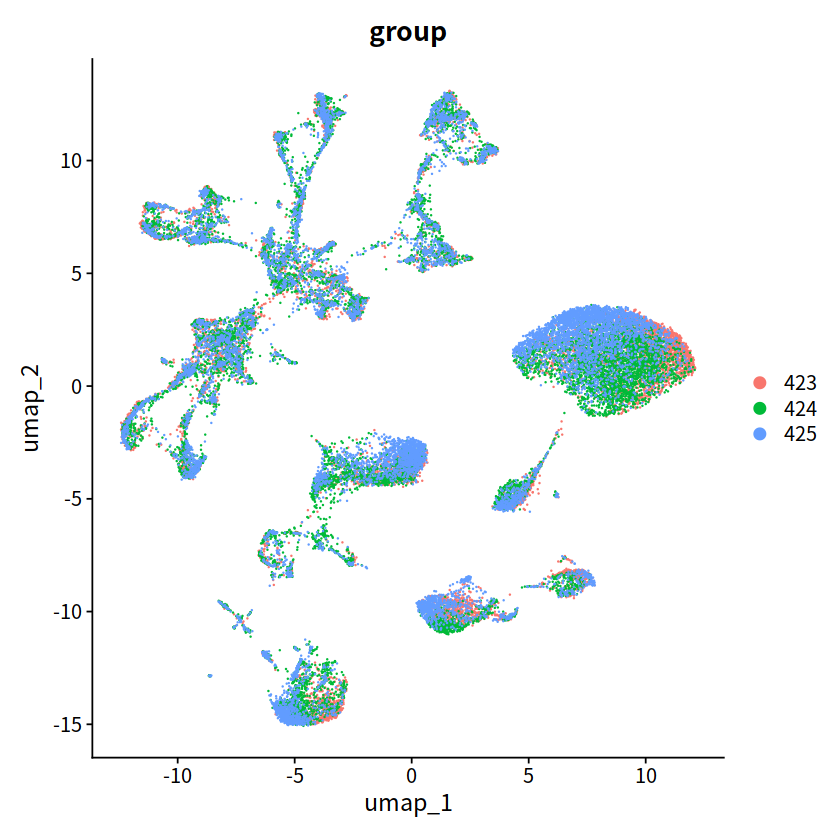

In [11]:
# UMAP降维
scRNA <- RunUMAP(scRNA, reduction="pca", dims=1:15, verbose=FALSE)
DimPlot(scRNA, reduction="umap", group.by = "group")

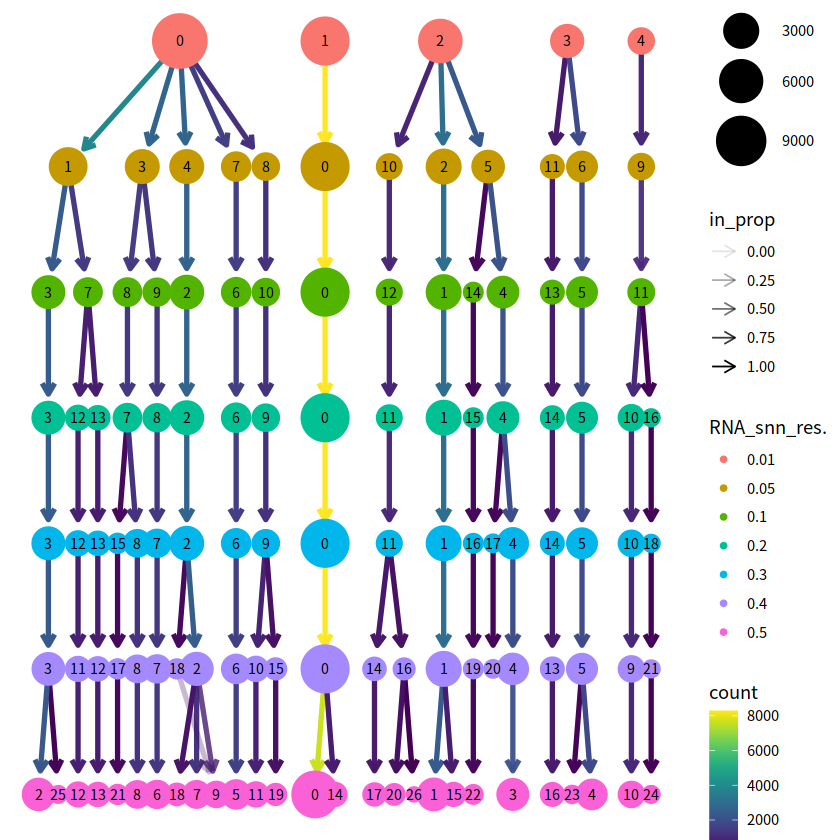

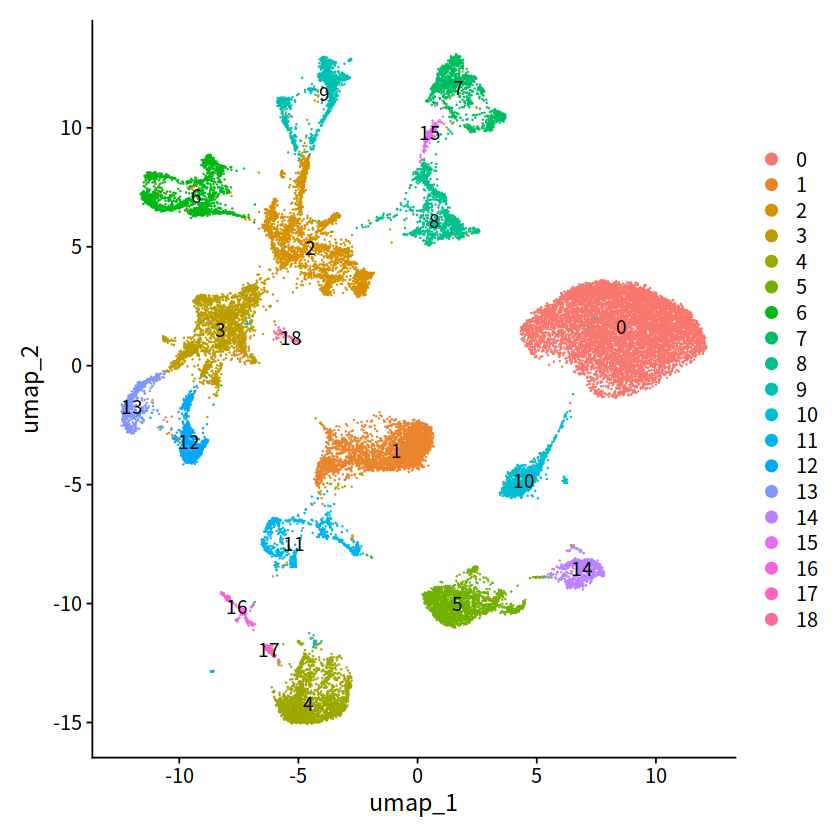

In [20]:
# 分群、细胞类型注释
scRNA <- FindNeighbors(scRNA, dims=1:15, verbose=FALSE)
scRNA <- FindClusters(scRNA, resolution=c(0.01,0.05,0.1,0.2,0.3,0.4,0.5), verbose=FALSE)

library(clustree)
clustree(scRNA@meta.data, prefix = "RNA_snn_res.")
ggsave("cluster图.png", width=10, height=10, dpi=600)
Idents(scRNA) <- scRNA$RNA_snn_res.0.3
DimPlot(scRNA, reduction="umap", label=TRUE)
ggsave("UMAP图.png", width=10, height=10, dpi=600)

In [25]:
table(scRNA@active.ident)
saveRDS(scRNA, file = "scRNA_tutorial.rds")  #保存数据，用于后续个性化分析


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
8294 2966 2656 2383 1999 1873 1546 1316 1187 1169  974  900  754  655  589  208 
  16   17   18 
 178  106   77 

#### 发现聚类一的所有biomarkers
```
cluster1.markers <- FindMarkers(scRNA, ident.1 = 1, min.pct = 0.25)
head(cluster1.markers, n = 5)
```
#### 查找将聚类5与聚类0和3区分的所有标记
```
cluster5.markers <- FindMarkers(scRNA, ident.1 = 5, ident.2 = c(0, 3), min.pct = 0.25)
head(cluster5.markers, n = 5)
```

#### 与所有其他细胞相比，找到每个簇的标记，仅报告阳性细胞
```
scRNA.marker <- FindAllMarkers(scRNA, only.pos = TRUE, min.pct = 0.25,
                               logfc.threshold = 0.25)
scRNA.marker %>% group_by(cluster) %>% top_n(n = 2, wt = avg_logFC)
```

In [35]:
scRNA.marker <- FindAllMarkers(scRNA, only.pos = TRUE, min.pct = 0.25,
                               logfc.threshold = 0.25, verbose=FALSE)

In [57]:
sig_marker = subset(scRNA.marker,scRNA.marker$p_val_adj < 0.05 & abs(scRNA.marker$avg_log2FC) > 0.5)

library(dplyr)
top2 <- sig_marker %>% group_by(cluster) %>% top_n(n=2, wt=avg_log2FC)

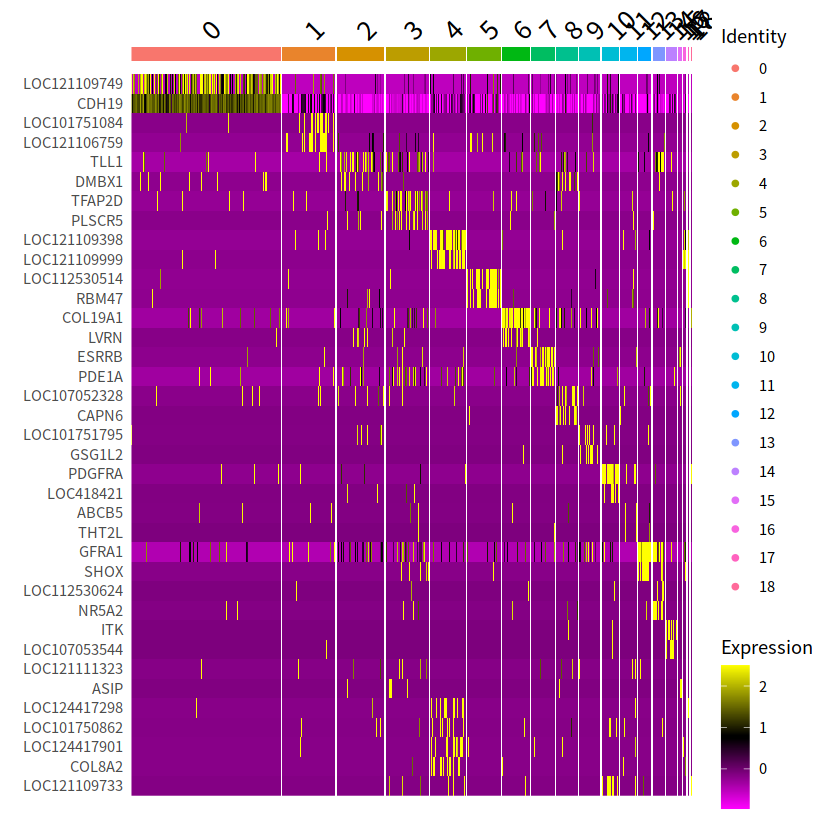

In [87]:
DoHeatmap(scRNA, features = top2$gene)
ggsave("基因表达量热图.png",width = 10, height = 10, dpi = 600)

#### 探索感兴趣的基因
- 小提琴图展示基因在每个cluster中的表达量
- 把基因表达量映射到UMAP结果
- 山脊图展示基因在每个cluster中的表达量

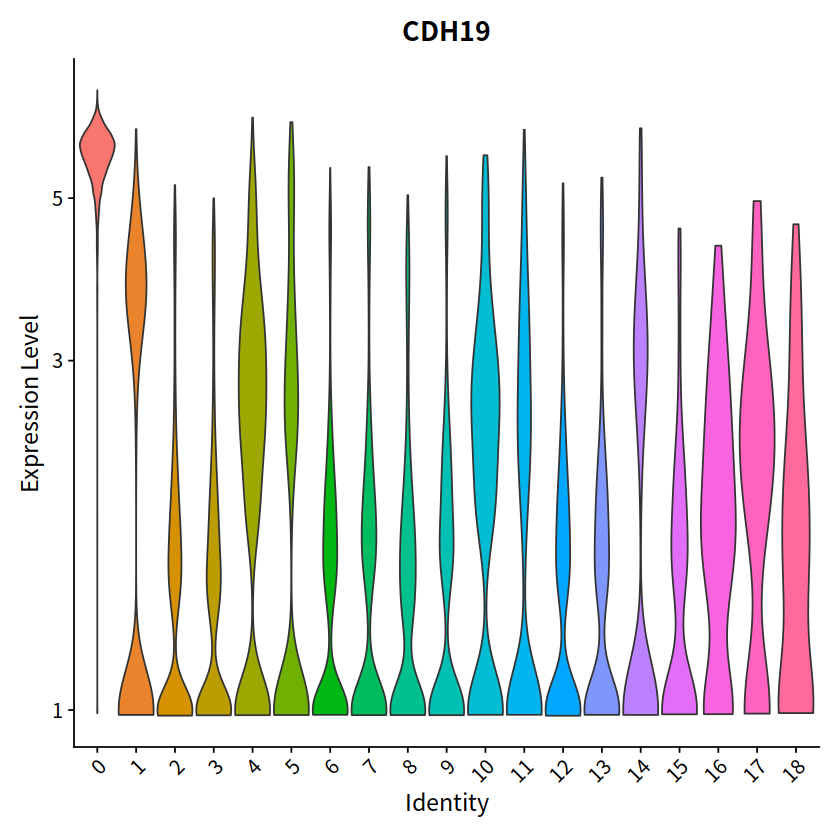

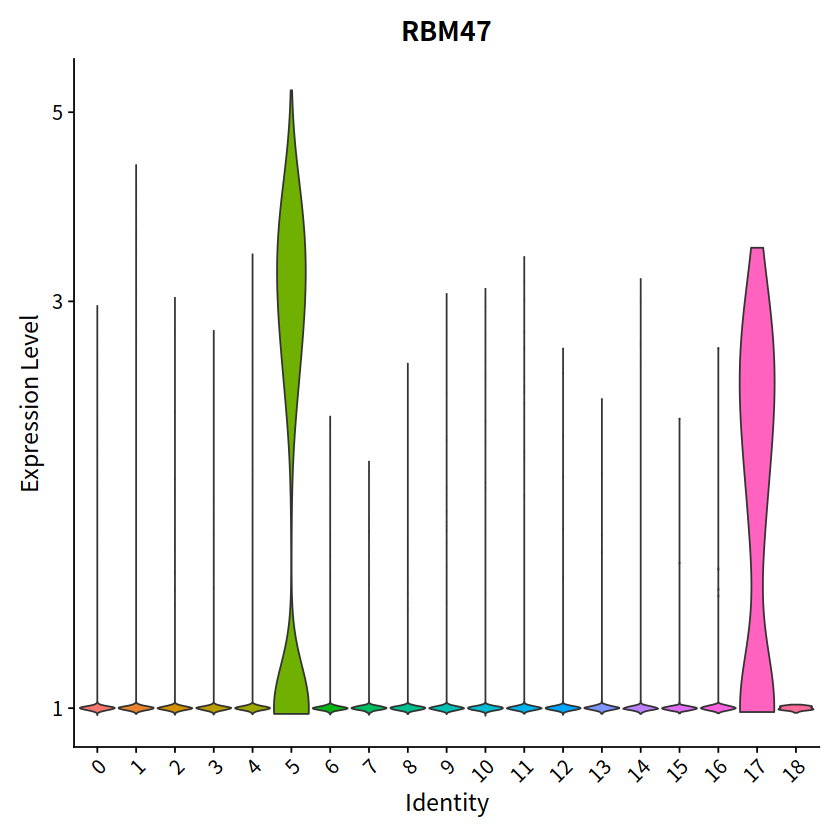

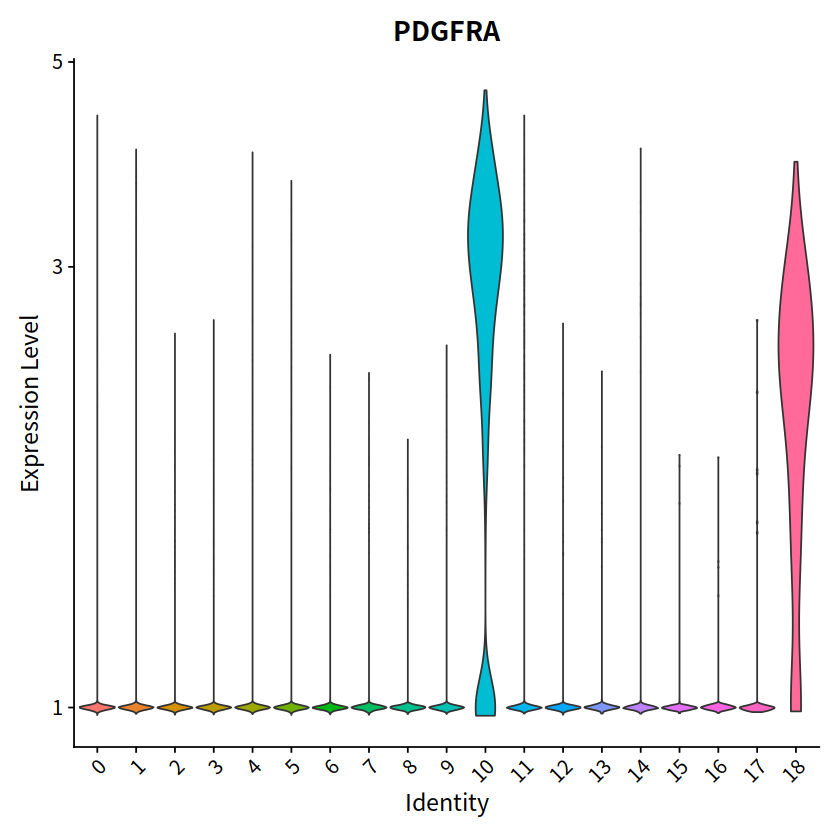

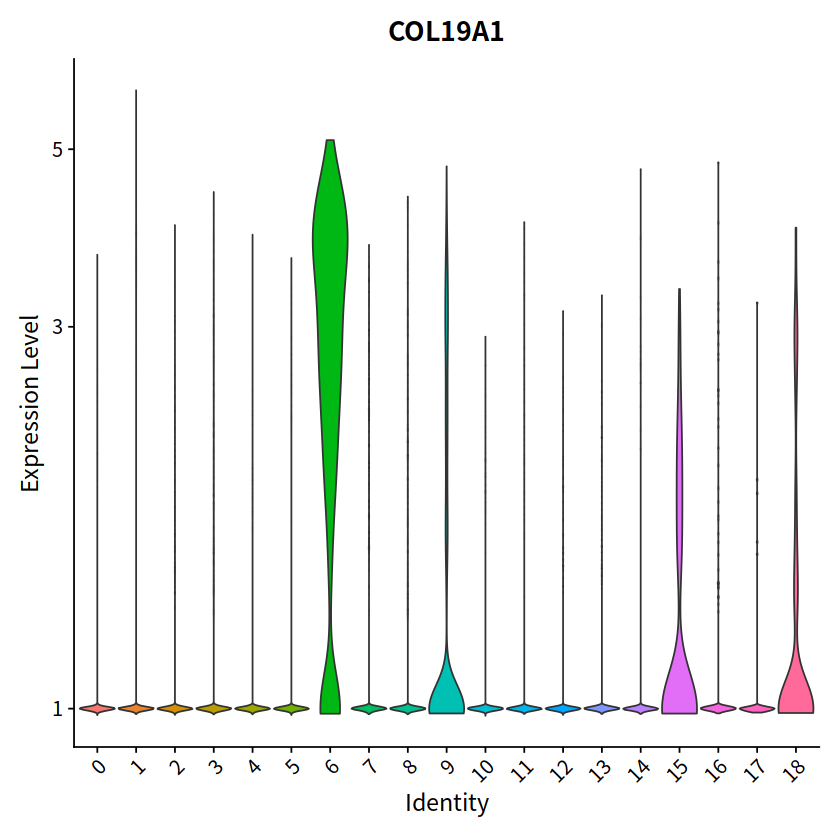

In [84]:
VlnPlot(scRNA, features = c("CDH19"), pt.size=0,log = TRUE) + NoLegend()
VlnPlot(scRNA, features = c("RBM47"), pt.size=0,log = TRUE) + NoLegend()
VlnPlot(scRNA, features = c("PDGFRA"), pt.size=0,log = TRUE) + NoLegend()

VlnPlot(scRNA, features = c("COL19A1"), pt.size=0,log = TRUE) + NoLegend()
ggsave("基因在每个细胞cluster上的表达量小提琴图.png",width = 10, height = 10, dpi = 600)

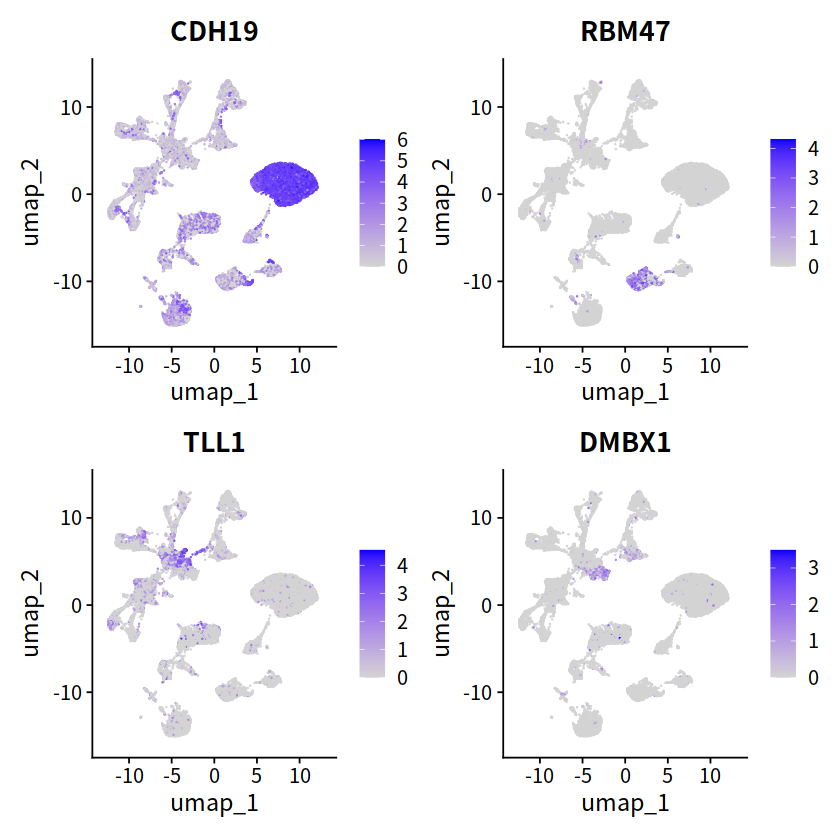

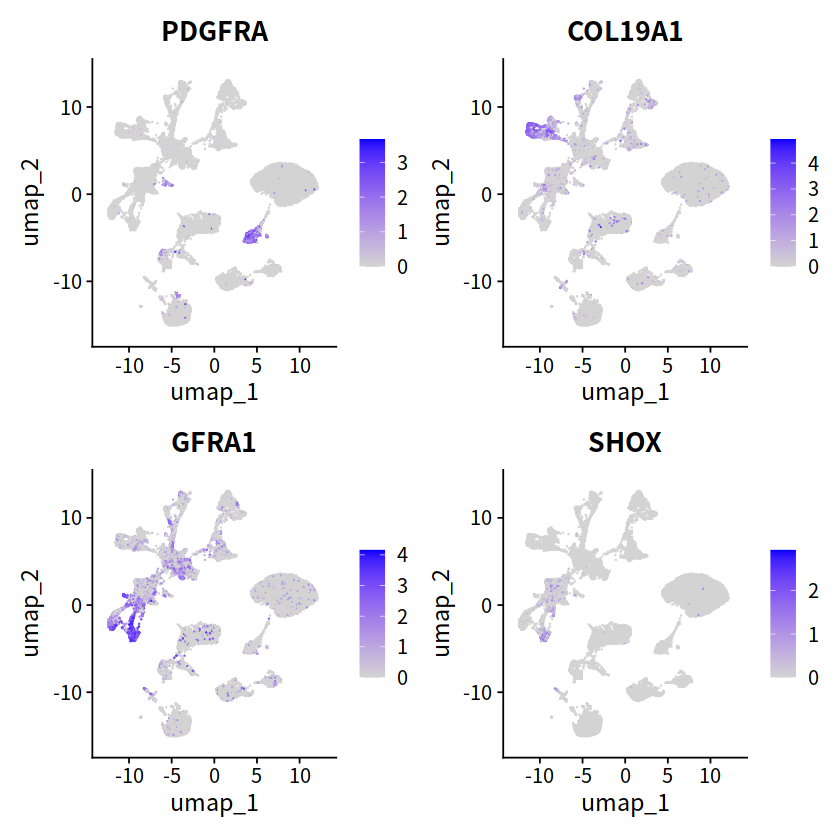

In [85]:
# 把基因表达量映射到UMAP结果
FeaturePlot(scRNA, features = c("CDH19", "RBM47", "TLL1", "DMBX1"))
ggsave("基因在每个细胞cluster上的表达量UMAP图.png",width = 10, height = 10, dpi = 600)

FeaturePlot(scRNA, features = c("PDGFRA", "COL19A1", "GFRA1", "SHOX"))

Picking joint bandwidth of 0.203

Picking joint bandwidth of 0.0634

Picking joint bandwidth of 0.0239

Picking joint bandwidth of 0.0285

Picking joint bandwidth of 0.203

Picking joint bandwidth of 0.0634

Picking joint bandwidth of 0.0239

Picking joint bandwidth of 0.0285

Picking joint bandwidth of 0.0239

Picking joint bandwidth of 0.0285

Picking joint bandwidth of 0.0265

Picking joint bandwidth of 0.00696



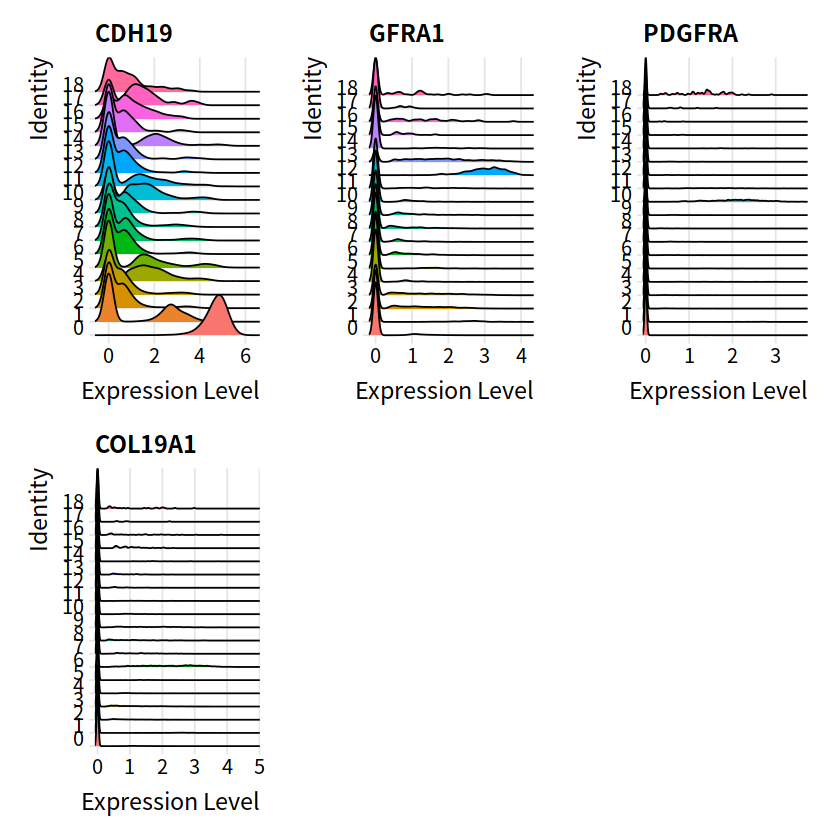

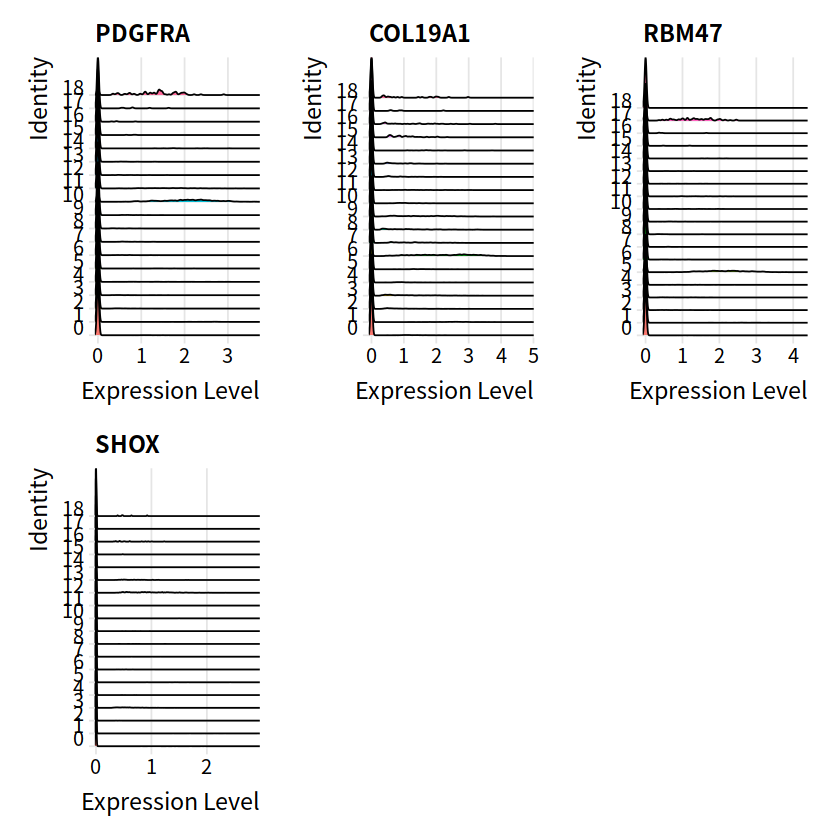

In [86]:
# 探索感兴趣的基因
RidgePlot(scRNA, features = c("CDH19", "GFRA1", "PDGFRA", "COL19A1"))
ggsave("基因在每个细胞cluster上的表达量山脊图.png",width = 20, height = 20, dpi = 600)

RidgePlot(scRNA, features = c("PDGFRA", "COL19A1", "RBM47", "SHOX"))

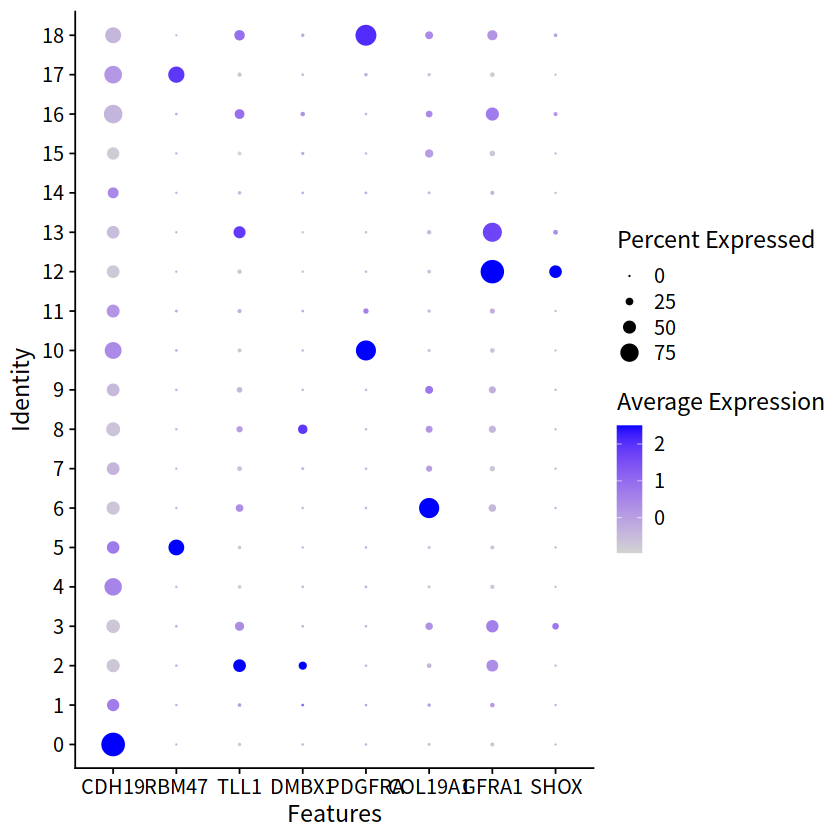

In [91]:
DotPlot(scRNA, features = c("CDH19", "RBM47", "TLL1", "DMBX1", "PDGFRA", "COL19A1", "GFRA1", "SHOX"))
ggsave("气泡图展示每个细胞cluster中基因的表达.png", width=10, height=10, dpi=600)

#### 识别细胞类型
- 目前先到这儿吧，这一步有点烦